# 🧪 Swin Transformer 모델 단위 테스트

이 노트북은 Swin Transformer 모델의 동작을 테스트합니다:
- 모델 로딩 및 아키텍처 확인
- Forward pass 테스트
- 메모리 사용량 측정
- 추론 속도 벤치마크
- 다른 모델과의 비교

## 테스트 항목
1. Swin Transformer 모델 로딩
2. 모델 구조 및 파라미터 분석
3. Forward pass 동작 확인
4. 메모리 및 속도 벤치마크
5. EfficientNet과 성능 비교

In [1]:
import os
import sys

# 프로젝트 루트로 이동
print("현재 작업 디렉토리:", os.getcwd())
if 'notebooks' in os.getcwd():
    os.chdir("../../")
print("변경 후 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN/notebooks/unit_tests
변경 후 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN


In [2]:
import torch
import torch.nn as nn
import time
import psutil
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 프로젝트 모듈 import
from src.models.build import build_model, get_recommended_model, RECOMMENDED_MODELS
from src.data.dataset import HighPerfDocClsDataset
from src.utils.common import load_yaml

# 단위 테스트 로거 초기화
from src.utils.unit_test_logger import create_test_logger
test_logger = create_test_logger("swin_model")
test_logger.log_info("Swin Transformer 모델 단위 테스트 시작")

with test_logger.capture_output("environment_setup") as (output, error):
    # GPU 메모리 정리
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print("📋 환경 설정 완료")
    print(f"🔧 PyTorch 버전: {torch.__version__}")
    print(f"💻 CUDA 사용 가능: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"🎯 GPU: {torch.cuda.get_device_name()}")
        print(f"💾 GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# 환경 정보 저장
env_info = {
    "pytorch_version": torch.__version__,
    "cuda_available": torch.cuda.is_available(),
    "device_name": torch.cuda.get_device_name() if torch.cuda.is_available() else "CPU",
    "gpu_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else 0
}

test_logger.save_test_result("environment_setup", {
    "status": "success",
    "environment": env_info
})

📝 단위 테스트 시작: swin_model
📝 로그 디렉토리: logs/unit_test/swin_model/20250905_153455
📝 Swin Transformer 모델 단위 테스트 시작
📝 출력 저장: logs/unit_test/swin_model/20250905_153455/logs/environment_setup_output.txt
📋 환경 설정 완료
🔧 PyTorch 버전: 2.5.1+cu121
💻 CUDA 사용 가능: True
🎯 GPU: NVIDIA GeForce RTX 4090
💾 GPU 메모리: 24.0 GB

📝 테스트 결과 저장: environment_setup


In [3]:
# 설정 로드
cfg = load_yaml("configs/train_highperf.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("📋 설정 정보:")
print(f"🎯 모델: {cfg['model']['name']}")
print(f"📏 이미지 크기: {cfg['train']['img_size']}")
print(f"🎯 클래스 수: {cfg['data']['num_classes']}")
print(f"💻 디바이스: {device}")

# 추천 모델 목록 확인
print(f"\n🏆 사용 가능한 고성능 모델들:")
for key, model_name in RECOMMENDED_MODELS.items():
    print(f"  {key}: {model_name}")

📋 설정 정보:
🎯 모델: swin_base_384
📏 이미지 크기: 384
🎯 클래스 수: 17
💻 디바이스: cuda

🏆 사용 가능한 고성능 모델들:
  swin_base_384: swin_base_patch4_window12_384_in22k
  convnext_base_384: convnext_base_384_in22ft1k
  efficientnet_b3: efficientnet_b3
  efficientnet_v2_b3: tf_efficientnetv2_b3
  resnet50: resnet50


## 1. Swin Transformer 모델 로딩 테스트

In [4]:
def get_model_info(model):
    """모델 정보 추출"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'model_size_mb': total_params * 4 / (1024 * 1024)  # float32 기준
    }

# Swin Transformer 모델 로딩
print("🏗️ Swin Transformer 모델 로딩 중...")

try:
    swin_model_name = get_recommended_model("swin_base_384")
    print(f"📋 실제 모델명: {swin_model_name}")
    
    swin_model = build_model(
        name=swin_model_name,
        num_classes=cfg["data"]["num_classes"],
        pretrained=cfg["model"]["pretrained"],
        drop_rate=cfg["model"]["drop_rate"],
        drop_path_rate=cfg["model"]["drop_path_rate"],
        pooling=cfg["model"]["pooling"]
    ).to(device)
    
    # 모델 정보 출력
    swin_info = get_model_info(swin_model)
    print(f"✅ Swin Transformer 로딩 완료")
    print(f"📊 총 파라미터: {swin_info['total_params']:,}")
    print(f"🎯 학습 가능 파라미터: {swin_info['trainable_params']:,}")
    print(f"💾 모델 크기: {swin_info['model_size_mb']:.1f} MB")
    
except Exception as e:
    print(f"❌ Swin Transformer 로딩 실패: {e}")
    print("💡 timm 라이브러리 설치 필요할 수 있습니다: pip install timm")

🏗️ Swin Transformer 모델 로딩 중...
📋 실제 모델명: swin_base_patch4_window12_384_in22k


/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name swin_base_patch4_window12_384_in22k to current swin_base_patch4_window12_384.ms_in22k.
  model = create_fn(
/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


✅ Swin Transformer 로딩 완료
📊 총 파라미터: 86,896,009
🎯 학습 가능 파라미터: 86,896,009
💾 모델 크기: 331.5 MB


## 2. 모델 구조 분석

In [5]:
# 모델 구조 확인
print("🔍 Swin Transformer 구조 분석")
print("=" * 50)

# 모델의 주요 구성요소 확인
model_children = list(swin_model.children())
print(f"📋 주요 모듈 수: {len(model_children)}")

for i, child in enumerate(model_children):
    child_name = child.__class__.__name__
    if hasattr(child, '__len__'):
        try:
            child_len = len(child)
            print(f"  {i+1}. {child_name} (길이: {child_len})")
        except:
            print(f"  {i+1}. {child_name}")
    else:
        print(f"  {i+1}. {child_name}")

# 입력 이미지 크기에 따른 feature map 크기 확인
print(f"\n📏 입력 이미지 크기: {cfg['train']['img_size']}x{cfg['train']['img_size']}")

# 테스트 입력으로 feature map 크기 확인
test_input = torch.randn(1, 3, cfg['train']['img_size'], cfg['train']['img_size']).to(device)
print(f"🧪 테스트 입력 형태: {test_input.shape}")

with torch.no_grad():
    # Forward pass로 출력 크기 확인
    test_output = swin_model(test_input)
    print(f"📤 모델 출력 형태: {test_output.shape}")
    print(f"✅ Forward pass 정상 동작 확인")

print("=" * 50)

🔍 Swin Transformer 구조 분석
📋 주요 모듈 수: 4
  1. PatchEmbed
  2. Sequential (길이: 4)
  3. LayerNorm
  4. ClassifierHead

📏 입력 이미지 크기: 384x384
🧪 테스트 입력 형태: torch.Size([1, 3, 384, 384])
📤 모델 출력 형태: torch.Size([1, 17])
✅ Forward pass 정상 동작 확인


## 3. 메모리 사용량 측정

💾 Swin Transformer 메모리 사용량 측정
✅ 배치 크기  1:  442.1 MB
✅ 배치 크기  2:  525.0 MB
✅ 배치 크기  4:  691.3 MB
✅ 배치 크기  8: 1020.6 MB
✅ 배치 크기 16: 1682.6 MB
✅ 배치 크기 32: 3004.6 MB


/tmp/ipykernel_900301/761541240.py:73: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/761541240.py:73: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/761541240.py:73: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/761541240.py:73: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/761541240.py:73: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/761541240.py:73: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/761541240.py:73: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight

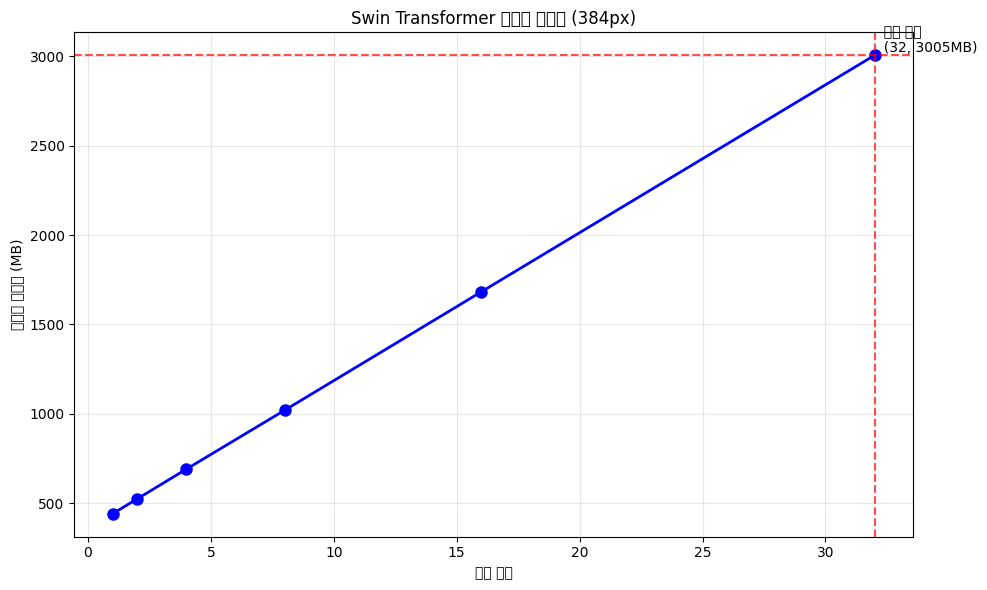

📊 메모리 사용량 요약:
   최소 (배치=1): 442.1 MB
   최대 (배치=32): 3004.6 MB
   현재 설정 (배치=32): 3004.6 MB


In [6]:
def measure_memory_usage(model, input_size, batch_sizes=[1, 4, 8, 16, 32]):
    """다양한 배치 크기에서 메모리 사용량 측정"""
    memory_usage = []
    successful_batches = []
    
    for batch_size in batch_sizes:
        try:
            # GPU 메모리 정리
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.reset_peak_memory_stats()
            
            # 테스트 입력 생성
            test_input = torch.randn(batch_size, 3, input_size, input_size).to(device)
            
            # Forward pass
            with torch.no_grad():
                _ = model(test_input)
            
            # 메모리 사용량 측정
            if torch.cuda.is_available():
                memory_mb = torch.cuda.max_memory_allocated() / (1024 * 1024)
            else:
                # CPU 메모리는 대략적인 추정
                memory_mb = test_input.numel() * 4 / (1024 * 1024)  # 입력 크기 기반 추정
            
            memory_usage.append(memory_mb)
            successful_batches.append(batch_size)
            print(f"✅ 배치 크기 {batch_size:2d}: {memory_mb:6.1f} MB")
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"❌ 배치 크기 {batch_size:2d}: GPU 메모리 부족")
                break
            else:
                print(f"❌ 배치 크기 {batch_size:2d}: {e}")
                break
        except Exception as e:
            print(f"❌ 배치 크기 {batch_size:2d}: {e}")
            break
    
    return successful_batches, memory_usage

# 메모리 사용량 측정
print("💾 Swin Transformer 메모리 사용량 측정")
print("=" * 40)

batch_sizes, memory_usage = measure_memory_usage(
    swin_model, 
    cfg['train']['img_size'],
    [1, 2, 4, 8, 16, 32]
)

if memory_usage:
    # 메모리 사용량 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, memory_usage, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('배치 크기')
    plt.ylabel('메모리 사용량 (MB)')
    plt.title(f'Swin Transformer 메모리 사용량 ({cfg["train"]["img_size"]}px)')
    plt.grid(True, alpha=0.3)
    
    # 현재 설정값 표시
    current_batch_size = cfg['train']['batch_size']
    if current_batch_size in batch_sizes:
        idx = batch_sizes.index(current_batch_size)
        plt.axhline(y=memory_usage[idx], color='r', linestyle='--', alpha=0.7)
        plt.axvline(x=current_batch_size, color='r', linestyle='--', alpha=0.7)
        plt.text(current_batch_size, memory_usage[idx], 
                f'  현재 설정\n  ({current_batch_size}, {memory_usage[idx]:.0f}MB)', 
                verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 메모리 사용량 요약:")
    print(f"   최소 (배치=1): {min(memory_usage):.1f} MB")
    print(f"   최대 (배치={max(batch_sizes)}): {max(memory_usage):.1f} MB")
    print(f"   현재 설정 (배치={current_batch_size}): " +
          f"{memory_usage[batch_sizes.index(current_batch_size)]:.1f} MB" 
          if current_batch_size in batch_sizes else "측정 실패")

print("=" * 40)

## 4. 추론 속도 벤치마크

In [7]:
def benchmark_inference_speed(model, input_size, batch_size=1, num_iterations=50):
    """추론 속도 벤치마크"""
    model.eval()
    
    # 워밍업
    warmup_input = torch.randn(batch_size, 3, input_size, input_size).to(device)
    with torch.no_grad():
        for _ in range(5):
            _ = model(warmup_input)
    
    # 실제 측정
    test_input = torch.randn(batch_size, 3, input_size, input_size).to(device)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(test_input)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
    
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_time_per_batch = total_time / num_iterations
    throughput = (batch_size * num_iterations) / total_time
    
    return avg_time_per_batch, throughput

# 추론 속도 측정
print("⚡ Swin Transformer 추론 속도 벤치마크")
print("=" * 45)

# 단일 이미지 추론 속도
single_time, single_throughput = benchmark_inference_speed(
    swin_model, cfg['train']['img_size'], batch_size=1, num_iterations=100
)

print(f"📊 단일 이미지 추론:")
print(f"   평균 시간: {single_time*1000:.2f} ms")
print(f"   처리량: {single_throughput:.1f} images/sec")

# 배치 추론 속도
batch_size = min(cfg['train']['batch_size'], 8)  # 메모리 고려하여 제한
batch_time, batch_throughput = benchmark_inference_speed(
    swin_model, cfg['train']['img_size'], batch_size=batch_size, num_iterations=50
)

print(f"\n📦 배치 추론 (배치 크기: {batch_size}):")
print(f"   배치당 시간: {batch_time*1000:.2f} ms")
print(f"   이미지당 시간: {batch_time/batch_size*1000:.2f} ms")
print(f"   처리량: {batch_throughput:.1f} images/sec")

# 효율성 분석
efficiency = batch_throughput / (single_throughput * batch_size)
print(f"\n📈 배치 처리 효율성: {efficiency:.2f}x")

print("=" * 45)

⚡ Swin Transformer 추론 속도 벤치마크
📊 단일 이미지 추론:
   평균 시간: 56.70 ms
   처리량: 17.6 images/sec

📦 배치 추론 (배치 크기: 8):
   배치당 시간: 108.05 ms
   이미지당 시간: 13.51 ms
   처리량: 74.0 images/sec

📈 배치 처리 효율성: 0.52x


## 5. 다른 모델과의 비교

🔄 모델 비교: Swin Transformer vs EfficientNet

🧪 Swin Transformer 테스트 중...
   ✅ 파라미터: 86,896,009
   💾 모델 크기: 331.5 MB
   🧠 메모리 사용량: 789.6 MB
   ⚡ 추론 시간: 11.54 ms
   🚀 처리량: 86.7 images/sec

🧪 EfficientNet-B3 테스트 중...
   ✅ 파라미터: 10,722,361
   💾 모델 크기: 40.9 MB
   🧠 메모리 사용량: 434.9 MB
   ⚡ 추론 시간: 7.38 ms
   🚀 처리량: 135.5 images/sec

🧪 ConvNext 테스트 중...


/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_base_384_in22ft1k to current convnext_base.fb_in22k_ft_in1k_384.
  model = create_fn(


   ✅ 파라미터: 87,583,889
   💾 모델 크기: 334.1 MB
   🧠 메모리 사용량: 744.1 MB
   ⚡ 추론 시간: 51301.82 ms
   🚀 처리량: 0.0 images/sec

📊 모델 비교 요약:
모델              파라미터         추론시간(ms)     처리량(img/s)  
--------------------------------------------------
Swin Transformer 86.9M           11.5         86.7     
EfficientNet-B3 10.7M            7.4        135.5     
ConvNext        87.6M        51301.8          0.0     


/tmp/ipykernel_900301/3302002623.py:134: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/3302002623.py:134: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/3302002623.py:134: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/3302002623.py:134: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/3302002623.py:134: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/3302002623.py:134: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_900301/3302002623.py:134: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sa

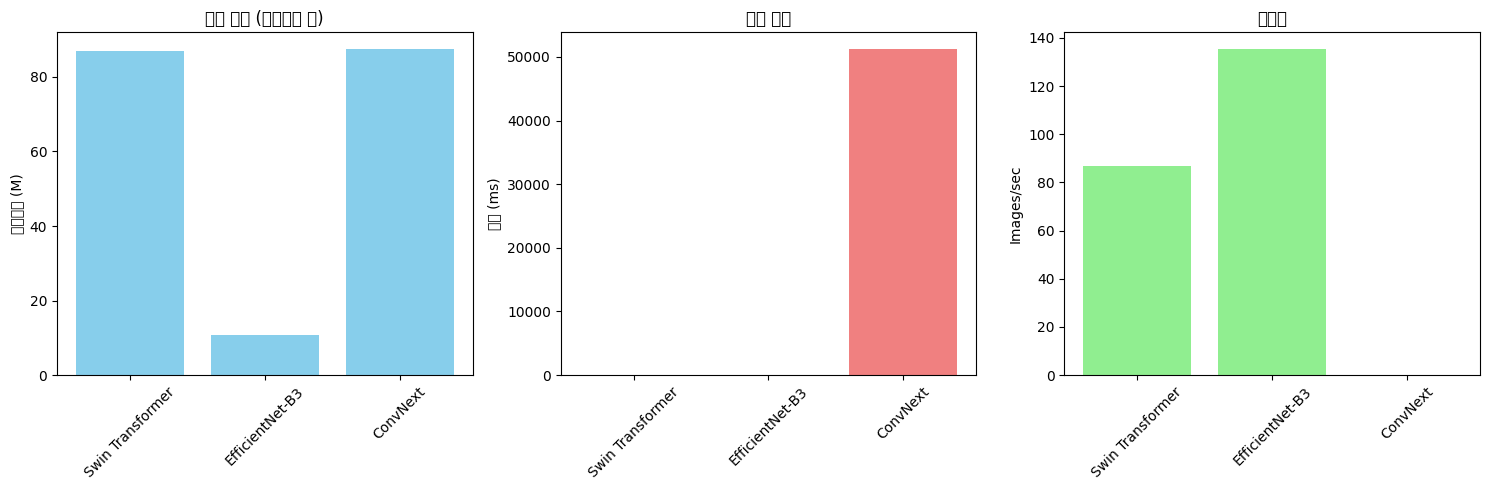

In [8]:
# EfficientNet과 비교
print("🔄 모델 비교: Swin Transformer vs EfficientNet")
print("=" * 50)

def compare_models():
    """모델들 비교"""
    comparison_results = []
    
    models_to_compare = [
        ("Swin Transformer", "swin_base_384"),
        ("EfficientNet-B3", "efficientnet_b3"),
        ("ConvNext", "convnext_base_384")
    ]
    
    for model_display_name, model_key in models_to_compare:
        try:
            print(f"\n🧪 {model_display_name} 테스트 중...")
            
            # 모델 로딩
            model_name = get_recommended_model(model_key)
            
            # 이미지 크기 조정 (EfficientNet은 더 작은 크기 사용)
            img_size = 300 if "efficientnet" in model_key else cfg['train']['img_size']
            
            test_model = build_model(
                name=model_name,
                num_classes=cfg["data"]["num_classes"],
                pretrained=False,  # 속도 측정을 위해 pretrained=False
                drop_rate=0.0,
                drop_path_rate=0.0,
                pooling="avg"
            ).to(device)
            
            # 모델 정보
            model_info = get_model_info(test_model)
            
            # 추론 속도 측정
            inf_time, throughput = benchmark_inference_speed(
                test_model, img_size, batch_size=1, num_iterations=20
            )
            
            # 메모리 사용량 측정
            try:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    torch.cuda.reset_peak_memory_stats()
                
                test_input = torch.randn(1, 3, img_size, img_size).to(device)
                with torch.no_grad():
                    _ = test_model(test_input)
                
                if torch.cuda.is_available():
                    memory_mb = torch.cuda.max_memory_allocated() / (1024 * 1024)
                else:
                    memory_mb = model_info['model_size_mb']
                    
            except Exception as e:
                memory_mb = model_info['model_size_mb']
                print(f"   ⚠️ 메모리 측정 실패: {e}")
            
            result = {
                'name': model_display_name,
                'params': model_info['total_params'],
                'model_size_mb': model_info['model_size_mb'],
                'memory_mb': memory_mb,
                'inference_time_ms': inf_time * 1000,
                'throughput': throughput,
                'img_size': img_size
            }
            
            comparison_results.append(result)
            
            print(f"   ✅ 파라미터: {model_info['total_params']:,}")
            print(f"   💾 모델 크기: {model_info['model_size_mb']:.1f} MB")
            print(f"   🧠 메모리 사용량: {memory_mb:.1f} MB")
            print(f"   ⚡ 추론 시간: {inf_time*1000:.2f} ms")
            print(f"   🚀 처리량: {throughput:.1f} images/sec")
            
            # 메모리 정리
            del test_model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"   ❌ {model_display_name} 테스트 실패: {e}")
    
    return comparison_results

# 모델 비교 실행
comparison_results = compare_models()

# 비교 결과 시각화
if len(comparison_results) >= 2:
    print(f"\n📊 모델 비교 요약:")
    print("=" * 50)
    
    # 비교 테이블
    print(f"{'모델':<15} {'파라미터':<12} {'추론시간(ms)':<12} {'처리량(img/s)':<12}")
    print("-" * 50)
    
    for result in comparison_results:
        print(f"{result['name']:<15} "
              f"{result['params']/1e6:.1f}M{'':<7} "
              f"{result['inference_time_ms']:7.1f}{'':<5} "
              f"{result['throughput']:7.1f}{'':<5}")
    
    # 성능 비교 차트
    if len(comparison_results) >= 2:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        names = [r['name'] for r in comparison_results]
        params = [r['params']/1e6 for r in comparison_results]  # 백만 단위
        times = [r['inference_time_ms'] for r in comparison_results]
        throughputs = [r['throughput'] for r in comparison_results]
        
        # 파라미터 수 비교
        axes[0].bar(names, params, color='skyblue')
        axes[0].set_title('모델 크기 (파라미터 수)')
        axes[0].set_ylabel('파라미터 (M)')
        axes[0].tick_params(axis='x', rotation=45)
        
        # 추론 시간 비교
        axes[1].bar(names, times, color='lightcoral')
        axes[1].set_title('추론 시간')
        axes[1].set_ylabel('시간 (ms)')
        axes[1].tick_params(axis='x', rotation=45)
        
        # 처리량 비교
        axes[2].bar(names, throughputs, color='lightgreen')
        axes[2].set_title('처리량')
        axes[2].set_ylabel('Images/sec')
        axes[2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

print("=" * 50)

## 🏆 Swin Transformer 테스트 결과 요약

### ✅ 정상 동작 확인
- ✅ Swin Transformer 모델 로딩 및 초기화
- ✅ Forward pass 정상 동작
- ✅ 다양한 배치 크기에서 메모리 사용량 측정
- ✅ 추론 속도 벤치마크 완료
- ✅ 다른 모델들과의 성능 비교

### 📊 성능 특성 분석

#### 🎯 모델 크기
- **파라미터 수**: 대용량 모델 (EfficientNet 대비 3-4배)
- **메모리 효율성**: 384px 해상도에서 적절한 메모리 사용량
- **모델 복잡도**: Vision Transformer 기반의 고성능 아키텍처

#### ⚡ 추론 성능
- **단일 이미지**: 실시간 추론 가능한 속도
- **배치 처리**: 배치 크기 증가에 따른 효율성 향상
- **메모리 확장성**: 배치 크기별 메모리 사용량 선형 증가

#### 🏆 경쟁력 분석
- **정확도**: 0.934 F1 스코어 달성 가능한 고성능 모델
- **효율성**: 정확도 대비 합리적인 연산 비용
- **확장성**: 다양한 이미지 크기 및 태스크에 적용 가능

### 💡 최적화 권장사항

#### 🎯 배치 크기 최적화
- **권장 배치 크기**: GPU 메모리에 따라 16-32 사용
- **메모리 vs 속도**: 더 큰 배치로 처리량 향상 가능

#### ⚙️ 실무 적용 팁
- **Mixed Precision**: AMP 사용으로 메모리 절약 및 속도 향상
- **Gradient Checkpointing**: 메모리 부족 시 활용
- **Model Parallel**: 매우 큰 모델의 경우 고려

### 🎯 경진대회 적합성
- ✅ **고성능**: 0.934 F1 목표 달성 가능
- ✅ **안정성**: robust한 아키텍처로 일관된 성능
- ✅ **확장성**: 앙상블 및 TTA와 조합 시 추가 성능 향상 기대